모든 class 사용, 각 class 별로 MS 구성한 뒤 나머지 class 데이터들로 각각 MD 구해보기

In [2]:
import cwru                      # Case Western Reserve University Bearing Data
import pandas as pd              # dataframe
import numpy as np               # array
from collections import Counter  # Class 갯수 세기
import matplotlib.pyplot as plt  # Visualization
%matplotlib inline
from scipy.fftpack import fft, ifft
from acoustics.cepstrum import complex_cepstrum, real_cepstrum
from sklearn.preprocessing import scale
from scipy.spatial import distance
from numpy.linalg import inv

In [175]:
cwru_data = cwru.CWRU("12DriveEndFault", "1750", 12000)

In [176]:
#cwru_data.labels

In [177]:
x_train = np.asarray(cwru_data.X_train)
x_test = np.asarray(cwru_data.X_test)

y_train = np.asarray(cwru_data.y_train)
y_test = np.asarray(cwru_data.y_test)

In [178]:
print(Counter(y_train)) # Train 데이터 클래스 분포
print(Counter(y_test))  # Test 데이터 클래스 분포

Counter({15: 30, 0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 7, 12: 7, 13: 7, 14: 7})
Counter({15: 10, 0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3})


In [179]:
# k class is abnormal
def make_dataset(NormalType, AbnormalType):
    no_tp = NormalType
    ab_tp = AbnormalType
    
    normal_train_idx, = np.where((y_train == no_tp))
    normal_test_idx, = np.where((y_test == no_tp))

    abnormal_train_idx, = np.where((y_train == ab_tp))
    abnormal_test_idx, = np.where((y_test == ab_tp))
    
    return normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx
    

In [182]:
normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx = make_dataset(8,14)  

In [184]:
def do_FFT(signal_set):
    window = np.hamming(12000)
    fft_rlt = np.fft.fft(window * signal_set)
    return(fft_rlt)

def do_Cepstrum(spectrum):
    cep_result = (ifft(np.log(spectrum**2))**2).real
    return(cep_result)

    #ifft(np.log(np.abs(spectrum)))

In [186]:
#Data split
normal_x_train = pd.DataFrame(x_train[normal_train_idx])
normal_x_test = pd.DataFrame(x_test[normal_test_idx])

abnormal_x_train = pd.DataFrame(x_train[abnormal_train_idx])
abnormal_x_test = pd.DataFrame(x_test[abnormal_test_idx])

abnormal_test = pd.concat([abnormal_x_train.reset_index(drop=True), abnormal_x_test.reset_index(drop=True)], axis = 0, ignore_index=True)

In [204]:
normal_x_test

,0,1,2,3,4,5,6,7,8,9,...,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
0,0.033949,-0.119065,-0.057340,0.142780,0.109644,-0.136770,-0.112243,0.177379,0.019492,-0.143430,...,-0.012508,-0.015594,-0.133847,-0.154638,0.096162,0.086903,-0.037360,0.053766,0.081542,-0.028101
1,-0.089502,0.070984,-0.015269,-0.164059,0.044832,0.146841,-0.097461,-0.220100,0.025177,0.048568,...,-0.011370,0.016244,0.051005,-0.004061,-0.023391,-0.020304,0.132385,0.107207,-0.026477,0.031512
2,0.093400,0.020142,-0.040771,0.019655,-0.003411,-0.033787,0.058802,0.086903,-0.062700,-0.184689,...,-0.259571,0.087877,0.219287,-0.207755,-0.205156,0.263795,0.097948,-0.206293,0.023391,0.223023


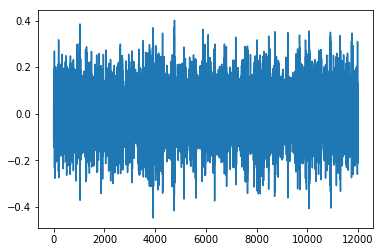

In [205]:
plt.plot(normal_x_test.iloc[0,:])

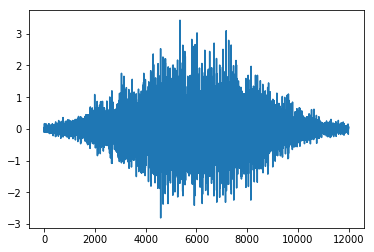

In [189]:
plt.plot(abnormal_x_test.iloc[0,:]*np.hamming(12000))

In [190]:
#Standardization
normal_x_train_scaled = pd.DataFrame(scale(normal_x_train, axis = 1))
normal_x_test_scaled = pd.DataFrame(scale(normal_x_test, axis = 1))

#abnormal_x_train_scaled = pd.DataFrame(scale(abnormal_x_train, axis = 1))
abnormal_x_test_scaled = pd.DataFrame(scale(abnormal_test, axis = 1))

'''
#No-Standardization
normal_x_train_scaled = normal_x_train
normal_x_test_scaled = normal_x_test

abnormal_x_train_scaled = abnormal_x_train
abnormal_x_test_scaled = abnormal_x_test
'''

'\n#No-Standardization\nnormal_x_train_scaled = normal_x_train\nnormal_x_test_scaled = normal_x_test\n\nabnormal_x_train_scaled = abnormal_x_train\nabnormal_x_test_scaled = abnormal_x_test\n'

In [191]:
#Hamming and FFT
normal_x_train_fft = np.apply_along_axis(do_FFT, 1, normal_x_train_scaled)
normal_x_test_fft = np.apply_along_axis(do_FFT, 1, normal_x_test_scaled)

#abnormal_x_train_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_train_scaled)
abnormal_x_test_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_test_scaled)

Text(0,0.5,'|Y(freq)|')

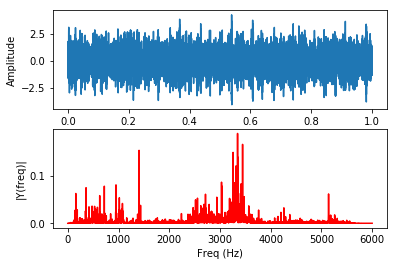

In [192]:
Fs = 12000.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

y = normal_x_train_scaled.iloc[0,:]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n/2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')


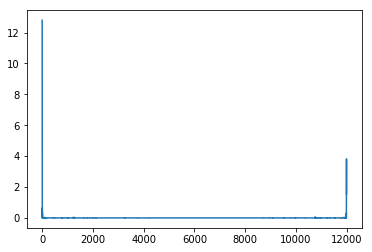

In [193]:
#Cepstrum
normal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_train_fft)
normal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_test_fft)

#abnormal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_train_fft)
abnormal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_test_fft)

plt.plot(abnormal_x_test_cep[0])

In [194]:
#SI Functions
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)
    
def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)


In [195]:
def make_df(x):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crestFactor_value, 'shape':shapeFactor_value, 'margin':marginFactor_value, 'impulse':impulseFactor_value})
    
    return(df)

In [196]:
#make dataframe
normal_x_train_SI = make_df(normal_x_train_cep)
normal_x_test_SI = make_df(normal_x_test_cep)

#abnormal_x_train_SI = make_df(abnormal_x_train_cep)
abnormal_x_test_SI = make_df(abnormal_x_test_cep)

In [197]:
np.mean(normal_x_train_SI['p2p'])

20.586016677642288

In [198]:
#Standardization in MTS
def standardize(x,y):
    mean_mean = get_mean(x['mean'])
    std_mean = get_mean(x['std'])
    skewness_mean = get_mean(x['skewness'])
    kurtosis_mean = get_mean(x['kurtosis'])
    p2p_mean = get_mean(x['p2p'])
    rms_mean = get_mean(x['rms'])
    crest_mean = get_mean(x['crest'])
    shape_mean = get_mean(x['shape'])
    margin_mean = get_mean(x['margin'])
    impulse_mean = get_mean(x['impulse'])
    
    mean_std = get_std(x['mean'])
    std_std = get_std(x['std'])
    skewness_std = get_std(x['skewness'])
    kurtosis_std = get_std(x['kurtosis'])
    p2p_std = get_std(x['p2p'])
    rms_std = get_std(x['rms'])
    crest_std = get_std(x['crest'])
    shape_std = get_std(x['shape'])
    margin_std = get_std(x['margin'])
    impulse_std = get_std(x['impulse'])
    
    mean_value = (y['mean'] - mean_mean) / mean_std
    std_value = (y['std'] - std_mean) / std_std
    skewness_value = (y['skewness'] - skewness_mean) / skewness_std
    kurtosis_value = (y['kurtosis'] - kurtosis_mean) / kurtosis_std
    p2p_value = (y['p2p'] - p2p_mean) / p2p_std
    rms_value = (y['rms'] - rms_mean) / rms_std
    crest_value = (y['crest'] - crest_mean) / crest_std
    shape_value = (y['shape'] - shape_mean) / shape_std
    margin_value = (y['margin'] - margin_mean) / margin_std
    impulse_value = (y['impulse'] - impulse_mean) / impulse_std
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crest_value, 'shape':shape_value, 'margin':margin_value, 'impulse':impulse_value})
    
    return(df)

In [232]:
normal_x_train_SI_scaled = standardize(normal_x_train_SI, normal_x_train_SI)
normal_x_test_SI_scaled = standardize(normal_x_train_SI, normal_x_test_SI)

#abnormal_x_train_SI_scaled = standardize(normal_x_train_SI, abnormal_x_train_SI)
abnormal_x_test_SI_scaled = standardize(normal_x_train_SI, abnormal_x_test_SI)

In [236]:
normal_x_train_SI_scaled.shape

(7, 10)

In [261]:
def get_MD_distance(x):
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled).corr()
    term = np.dot(x, inv(normal_cov_mat))
    dist = np.dot(term, x.T) / len(x)
    return(dist)

In [262]:
get_MD_distance(normal_x_test_SI_scaled.iloc[0,:])

-2357054243.0423827

In [271]:
normal_train_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_train_SI_scaled)
normal_train_dist.sort()
normal_test_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_test_SI_scaled)
normal_test_dist.sort()

#abnormal_train_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_train_SI_scaled)
#abnormal_train_dist.sort()
abnormal_test_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_test_SI_scaled)
abnormal_test_dist.sort()


In [272]:
print(normal_train_dist)
print('\n')
print(normal_test_dist)
print('\n')
#print(abnormal_train_dist)
#print('\n')
print(abnormal_test_dist)


[0.09401342 0.30807675 0.44993859 0.59969871 0.61298795 0.61883049
 0.64213991]


[-3.22258897e+09 -2.35705424e+09 -1.00782677e+09]


[2.84018270e+14 3.14586216e+14 6.00631719e+14 8.82900854e+14
 8.96452388e+14 1.03243416e+15 1.59331567e+15 2.52279558e+15
 2.54764819e+15 2.98832878e+15]


In [206]:
#L_12(2^11) orthogonal array
ortho_array = np.matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
                       [1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2],
                       [1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2],
                       [1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1],
                       [1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1],
                       [2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1],
                       [2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2],
                       [2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1],
                       [2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2],
                       [2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2],
                       [2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1]])

In [207]:
otho_df = pd.DataFrame(ortho_array, columns=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse','DUMMY'])

In [208]:
def get_exp_col(n):
    condition = otho_df.iloc[n,:]==1
    col = list(otho_df.loc[n,condition].index)
    if('DUMMY' in col):
        col.pop()
    return(col)

In [209]:
def get_MD_distance_exp(x,n):
    col = get_exp_col(n)
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled[col]).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [210]:
def get_MD_exp(n,df):
    col = get_exp_col(n)
    target_df = df[col]
    dist = np.apply_along_axis(get_MD_distance_exp, 1, target_df, n)
    return(dist)

In [211]:
def get_MD_matrix(df):
    arr = np.empty([12, df.shape[0]])
    for i in range(0,12):
        arr[i,:] = get_MD_exp(i,df)
        
    return(arr)

In [212]:
normal_x_test_MD_matrix = get_MD_matrix(normal_x_test_SI_scaled)

#abnormal_x_train_MD_matrix = get_MD_matrix(abnormal_x_train_SI_scaled)
abnormal_x_test_MD_matrix = get_MD_matrix(abnormal_x_test_SI_scaled)


In [213]:
def cal_larger_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(1/(dist)))
        SNRatio.append(SN)
        
    return(SNRatio)

In [214]:
def cal_smaller_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(dist))
        SNRatio.append(SN)
        
    return(SNRatio)

In [215]:
SNRatio_normal_test = cal_smaller_better_SNRatio(normal_x_test_MD_matrix)

#SNRatio_abnormal_train = cal_larger_better_SNRatio(abnormal_x_train_MD_matrix)
SNRatio_abnormal_test = cal_larger_better_SNRatio(abnormal_x_test_MD_matrix)

/usr/local/anaconda/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


In [216]:
def cal_smaller_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_smaller_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [217]:
def cal_larger_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_larger_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [218]:
#get gain
column_names=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse']

def get_normal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_smaller_better_gain(normal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)
 
def get_abnormal_train_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_train_MD_matrix, columns[i]))
        
    return(gain_values)

def get_abnormal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)

In [219]:
normal_test_gain = get_normal_test_gain(column_names)

#abnormal_train_gain = get_abnormal_train_gain(column_names)
abnormal_test_gain = get_abnormal_test_gain(column_names)

/usr/local/anaconda/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


In [220]:
print('normal_test_gain')
print(pd.DataFrame(normal_test_gain, index=column_names))
print('\n')

#print('abnormal_train_gain')
#print(pd.DataFrame(abnormal_train_gain, index=column_names))
#print('\n')

print('abnormal_test_gain')
print(pd.DataFrame(abnormal_test_gain, index=column_names))

normal_test_gain
           0
mean     NaN
std      NaN
skewness NaN
kurtosis NaN
p2p      NaN
rms      NaN
crest    NaN
shape    NaN
margin   NaN
impulse  NaN


abnormal_test_gain
           0
mean     NaN
std      NaN
skewness NaN
kurtosis NaN
p2p      NaN
rms      NaN
crest    NaN
shape    NaN
margin   NaN
impulse  NaN


In [362]:
neg_idx, = np.where((np.array(normal_test_gain) < 0) & (np.array(abnormal_test_gain) < 0))

exclude_var_names = np.array(column_names)[neg_idx]
print(exclude_var_names)    
print(pd.DataFrame(normal_test_gain, index = column_names).sort_values(by=0))

['kurtosis']
                 0
crest    -1.022004
p2p      -0.631653
impulse  -0.494045
shape    -0.381940
skewness -0.365115
rms      -0.358464
kurtosis -0.310769
std      -0.267136
mean     -0.112347
margin    0.190902


In [366]:
# Select variables that show positive SN ratio in Normal test
#'mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse'

variables = ['mean', 'std', 'skewness', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse']

normal_train_taguchi = normal_x_train_SI_scaled[variables]
normal_test_taguchi = normal_x_test_SI_scaled[variables]

#abnormal_train_taguchi = abnormal_x_train_SI_scaled[variables]
abnormal_test_taguchi = abnormal_x_test_SI_scaled[variables]

def get_MD_distance_taguchi(x):
    normal_cov_mat = pd.DataFrame(normal_train_taguchi).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

normal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_train_taguchi)
normal_train_dist_taguchi.sort()
normal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_test_taguchi)
normal_test_dist_taguchi.sort()

#abnormal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_train_taguchi)
#abnormal_train_dist_taguchi.sort()
abnormal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_test_taguchi)
abnormal_test_dist_taguchi.sort()

# Results of Feature selection
print('Normal Train (Mahalanobis Space)')
print(normal_train_dist_taguchi)
print('\n')

print('Normal Test')
print(normal_test_dist_taguchi)
print('\n')

#print('Abnormal Train')
#print(abnormal_train_dist_taguchi)
#print('\n')

print('Abnormal Test')
print(abnormal_test_dist_taguchi)

Normal Train (Mahalanobis Space)
[0.39079147 0.410807   0.41169375 0.44752636 0.4697522  0.48228136
 0.49675981 0.54760224 0.68064912 0.68566601 0.72183211 0.73316098
 0.73497556 0.77485714 0.78993768 0.82202745 0.88583956 0.95410033
 0.96089915 1.00362443 1.05861486 1.10658184 1.21060688 1.4020961
 1.99790245 2.18525843 2.80837518 2.82555761]


Normal Test
[0.44365891 0.50702676 0.55417315 0.79727684 1.13419851 2.07659162
 2.08015595 2.73140761 2.82961825 4.32864333 4.90532291 5.46634591]


Abnormal Test
[ 3.35445557  4.22770947  5.44020827  5.59516395  8.04937588  8.4129645
  8.69352125 10.91886843 17.43306754 24.77844786]
